In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
batch_size = 32
image_h = 180
image_w = 180

In [5]:
data_dir = r"F:\Internship Project\data"

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    color_mode="grayscale",
    subset="training",
    seed=123,
    image_size=(image_h, image_w),
    batch_size=batch_size)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    color_mode="grayscale",
    subset="validation",
    seed=123,
    image_size=(image_h, image_w),
    batch_size=batch_size)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [8]:
test_size = int(0.5 * len(val_ds))
test_ds = val_ds.take(test_size)
val_ds = val_ds.skip(test_size)

len(test_ds), len(val_ds)

(24, 24)

In [9]:
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


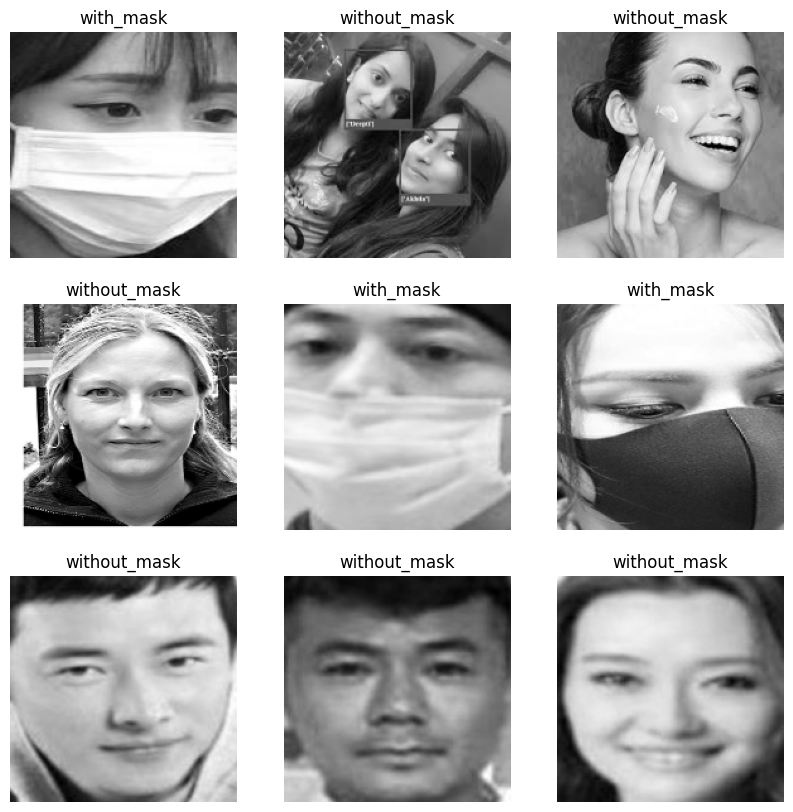

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 1)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(image_h, image_w),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [19]:
num_class = len(class_names)

model = tf.keras.Sequential([
    preprocess,
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(batch_size, image_h, image_w, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_class, activation='softmax')
])

model.build(input_shape=(batch_size, image_h, image_w, 1))

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 179, 179, 32)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 88, 88, 64)        8256      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 44, 44, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 43, 43, 128)      

In [21]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy', recall_m, precision_m, f1_m])

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
189/189 [==============================] - 45s 215ms/step - loss: 0.6345 - accuracy: 0.6523 - recall_m: 1.0000 - precision_m: 0.5088 - f1_m: 0.6694 - val_loss: 0.7285 - val_accuracy: 0.6267 - val_recall_m: 1.0000 - val_precision_m: 0.5217 - val_f1_m: 0.6806
Epoch 2/10
189/189 [==============================] - 41s 219ms/step - loss: 0.5076 - accuracy: 0.7523 - recall_m: 1.0000 - precision_m: 0.5088 - f1_m: 0.6694 - val_loss: 0.7216 - val_accuracy: 0.5916 - val_recall_m: 1.0000 - val_precision_m: 0.5217 - val_f1_m: 0.6806
Epoch 3/10
189/189 [==============================] - 42s 221ms/step - loss: 0.4707 - accuracy: 0.7781 - recall_m: 1.0000 - precision_m: 0.5088 - f1_m: 0.6694 - val_loss: 0.6679 - val_accuracy: 0.6482 - val_recall_m: 1.0000 - val_precision_m: 0.5217 - val_f1_m: 0.6806
Epoch 4/10
189/189 [==============================] - 44s 233ms/step - loss: 0.4271 - accuracy: 0.7999 - recall_m: 1.0000 - precision_m: 0.5088 - f1_m: 0.6694 - val_loss: 0.6528 - val_accuracy:

In [24]:
scores = model.evaluate(test_ds)

24/24 [==============================] - 2s 35ms/step - loss: 0.5556 - accuracy: 0.7383 - recall_m: 1.0000 - precision_m: 0.5000 - f1_m: 0.6626
